In [1]:
!python --version

Python 2.7.10 :: Anaconda 2.4.0 (64-bit)


In [2]:
import logging, gensim, bz2
from gensim import corpora, models, similarities
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
from bs4 import BeautifulSoup
import nltk
import re
from nltk.corpus import stopwords
import string
import itertools
import random
exclude = set(string.punctuation)
import matplotlib
matplotlib.rcParams['figure.figsize'] = (18.0, 18.0)

# Load text

In [3]:
def loadText(path):
    soup = BeautifulSoup( open(path), 'lxml')
    s = ''
    for string in soup.find_all("source"):
        s += string.string
    return s

In [4]:
text = loadText(u"all_source_texts/Turkish_Basketball_Clubs_Evaluationprogramme15-16_Repucom_150612_Übersetzten-en-tr-T.mxliff")

# tokenize

In [5]:
from nltk.stem.wordnet import WordNetLemmatizer
def tokenize(text):
    text = text.lower()
    # tokenize + punctuation
    from nltk.tokenize import RegexpTokenizer
    tokenizer = RegexpTokenizer(r'\w+') # remove punctuation
    text = tokenizer.tokenize(text)
    # remove stopwords
    from nltk.corpus import stopwords
    stops = stopwords.words('english')
    text = [ w for w in text if w.lower() not in stops]
    # Exclude numbers
    text = [s for s in text if not re.search(r'\d',s)]
    #remove word with less than 3letters
    text = [s for s in text if len(s) > 2]
    # stemmer
    lmtzr = WordNetLemmatizer()
    # porter = nltk.PorterStemmer()
    text =  [lmtzr.lemmatize(t) for t in text] 
    return text

In [6]:
tokens =  tokenize(text)

# load all texts

In [7]:
import os
import sys
filelist = []
root = u"all_source_texts/"
for filename in os.listdir(root):
    filename = root + filename
    filelist .append(filename.encode(sys.getfilesystemencoding()))

i = 0
corpus_tokens = {}
for f in filelist:
    corpus_tokens[f] = tokenize(loadText( f ))
    i += 1


# Load LDA

In [8]:
lda = gensim.models.ldamodel.LdaModel.load(u'lda/wikipedia_lda', mmap='r')

# make dictionary

In [9]:
corpus = { f:lda.id2word.doc2bow(corpus_tokens[f]) for f in corpus_tokens}

# update lda 

In [10]:
lda.update( corpus.values())

In [11]:
# dictionary.save('dict_corpus')

In [12]:
for f in filelist:
    topic = lda.get_document_topics(corpus[f])
    print(f + "  " + str(sum([ s[1] for s in topic])) )

all_source_texts/13_pd_spec_fortigel_b-en-ru-T.mxliff  0
all_source_texts/140702_swatch_SOM_A4_preview-en-fr-T.mxliff  0
all_source_texts/1410-0002 DEEP SEA MONSTER Press Outs-en-fr_ca-CR.mxliff  0
all_source_texts/1410-0002 FAST FLESH EATERS pressouts-en-fr_ca-CR.mxliff  0
all_source_texts/1410-0002 fearsome fighters Press Outs-en-fr_ca-CR.mxliff  0
all_source_texts/1410-0002 Giants of the Jurassic pressouts-en-fr_ca-CR.mxliff  0
all_source_texts/1410-0002 Killers of Cretaceous pressouts-en-fr_ca-CR.mxliff  0
all_source_texts/1410-0002 mega meateater pressouts -en-fr_ca-CR.mxliff  0
all_source_texts/1814_Imbox Imagebrochure_REN 2_2015-8-20-en-de-T.mxliff  0
all_source_texts/1844 0010 S&A MY BIG BOOK OF STICKER FUN COVER-en-fr_ca-CR.mxliff  0
all_source_texts/1844 0010 S&A MY BIG BOOK OF STICKER FUN INTERIORS 1-8-en-fr_ca-CR.mxliff  0
all_source_texts/1844 0010 S&A MY BIG BOOK OF STICKER FUN INTERIORS 25-40-en-fr_ca-CR.mxliff  0
all_source_texts/1844 0010 S&A MY BIG BOOK OF STICKER FUN

# get topic distribution from a text

In [13]:
def topicsFromFiles( path ):
    tokens = tokenize(loadText( path ))
    bow = lda.id2word.doc2bow( tokens )
    return lda.get_document_topics(bow)

In [14]:
f = random.choice(filelist)
topicsFromFiles(f)

[(25, 0.081799737769006189),
 (48, 0.20161098062206484),
 (72, 0.28043114906169542),
 (78, 0.22251222938355553),
 (83, 0.014926498638338516),
 (89, 0.19108517540606648)]

# store topics words

In [15]:
# translate the lda topics in dictionnaries
i = 0
n = 100 # number of words per topics
topics = dict()
wordset = set()
for i in range(0,100):
    a = lda.print_topic(i, n)
    topic = dict()
#     print a
    pairs = a.split( ' + ')
    for p in pairs:
        pair = p.split('*')
#         print pair[0]
        value = float(pair[0])
        key = unicode(pair[1])
        topic[key] = value
        wordset.add(key)
    topics[i] = topic   
    i += 1

# show topic as a bag of words

In [16]:
import PIL
from os import path
from wordcloud import WordCloud
matplotlib.rcParams['figure.figsize'] = (15.0, 8.0)
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

def WordCloudTopic( i ):
    # Generate a word cloud image
    wc = WordCloud(background_color="white", max_words=2000,
               max_font_size=40, random_state=42)
    wordcloud = wc.generate_from_frequencies(topics[i].items())    
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

C:\Anaconda3\envs\py27\lib\site-packages\PIL\ImageDraw.py:104: UserWarning: setfont() is deprecated. Please set the attribute directly instead.
  "Please set the attribute directly instead.")


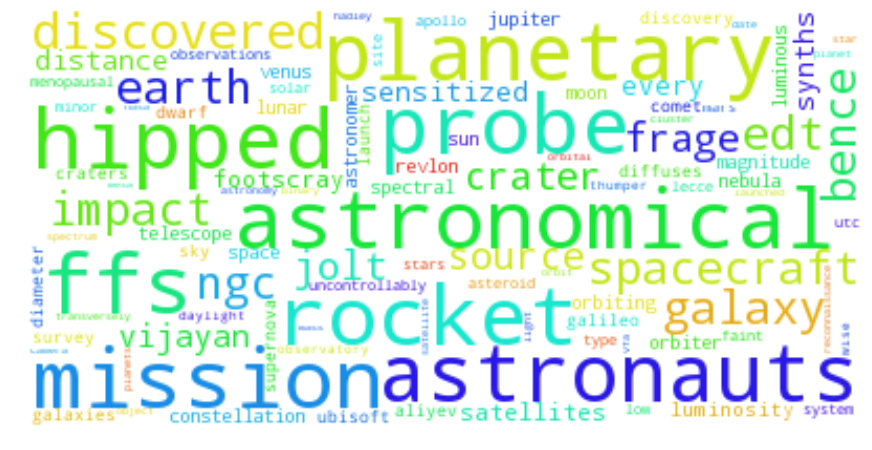

In [17]:
matplotlib.rcParams['figure.figsize'] = (15.0, 8.0)
WordCloudTopic(0)

# get the topic and the score for a unique word

In [18]:
def getTopicFromWord( unique_word ):
    bow = lda.id2word.doc2bow( [unique_word] )
    topic = lda.get_document_topics(bow)
    if len(topic):
        return topic[0][0]
    else:
        return None


print getTopicFromWord('have')

None


In [73]:
from scipy.sparse import *
from scipy import *
V = dok_matrix((0,100), dtype=float32)

def getTopic_n_topWordsWithinTopics( path ):
    tokens = tokenize(loadText( path ))
    bow = lda.id2word.doc2bow( tokens )
    topics =  lda.get_document_topics(bow)
    complex_topic = dict()
    complex_topic['topics'] = topics
    details = dict()
    max_details = 0
    for t in tokens:
        i = getTopicFromWord( t )
        if i != None:
            if i not in details.keys():
                details[i]  = dict()
            if t not in details[i].keys():
                details[i][t] = 1
            else:
                details[i][t] += 1
                if details[i][t] > max_details:
                    max_details = details[i][t]
                
    V = dok_matrix((1,100), dtype=float32)
    for t in topics:
        V[0,t[0]] = t[1]
    
    complex_topic['semantic_vector'] = V
    complex_topic['details'] = details
    complex_topic['max_details'] = max_details
    return complex_topic


In [74]:
complex_topics = dict()
for f in filelist:
    complex_topics[f] = getTopic_n_topWordsWithinTopics(f)

# display main topics and the top words from the text within a topic

In [123]:
f = random.choice(filelist)
x = complex_topics[f]
x_topics = x['topics']
x_details = x['details']
for i in sorted(x_topics, key=lambda tup: tup[1], reverse = True):
    print "score: %s " %i[1]
    d = x_details[i[0]]
    for w in sorted(d, key=d.get, reverse=True)[:10]:
        print "-----  " + str(w) + ": " + str(d[w])

score: 0.354519371978 
-----  roll: 13
-----  mill: 6
-----  belt: 6
-----  hydraulic: 4
-----  automatic: 4
-----  design: 3
-----  stainless: 3
-----  machine: 3
-----  hoist: 3
-----  adjustment: 2
score: 0.237315563096 
-----  com: 15
-----  phone: 13
-----  system: 11
-----  support: 3
-----  provides: 3
-----  optional: 3
-----  customer: 3
-----  control: 2
-----  offer: 2
-----  www: 1
score: 0.234426420528 
-----  sale: 6
-----  provide: 4
-----  global: 3
-----  adjustment: 3
-----  maintenance: 3
-----  ltd: 3
-----  market: 2
-----  relevant: 1
-----  strategic: 1
-----  technician: 1
score: 0.042523573599 
-----  feed: 16
-----  plant: 2
-----  toothed: 1
-----  illustration: 1
-----  length: 1
-----  distribution: 1
score: 0.0376072437696 
-----  paladin: 9
-----  overload: 4
-----  grease: 3
-----  infinitely: 1
-----  setting: 1
-----  unmatched: 1
-----  suit: 1
score: 0.0287551512556 
-----  die: 10
-----  auf: 4
-----  germany: 2
-----  graz: 1
-----  austria: 1
scor

# similarity

In [128]:
def norm(v):
    s = 0
#     it = v.itervalues()
#     while it:
#         s+= it
#         it.next()
    for d in v.itervalues():
        s+= d**2
    return sqrt(s)

def similarity( a, b):
    # cosine similarity
    p = (a.dot(b.transpose()) / (norm(a) * norm(b))).data
    if len(p):
        return p[0]


def closestFile( path ):
    x = getTopic_n_topWordsWithinTopics(path)
    u = x['semantic_vector']
    print type(u)
    similarities = dict()
    for s in complex_topics:
        v = complex_topics[s]['semantic_vector']
        similarities[s] = similarity(v,u)     
    k = 1
    for i in sorted(similarities.items(), key=lambda x: x[1])[::-1][:15]:
        print str(k) + "  |  "  + str(i)
        k += 1
        
    return similarities

In [129]:
path = u"all_source_texts/Turkish_Basketball_Clubs_Evaluationprogramme15-16_Repucom_150612_Übersetzten-en-tr-T.mxliff"
closestFile( path )

<class 'scipy.sparse.dok.dok_matrix'>
1  |  ('all_source_texts/Turkish_Basketball_Clubs_Evaluationprogramme15-16_Repucom_150612_\xdcbersetzten-en-tr-T.mxliff', 0.99999997008349395)
2  |  ('all_source_texts/ilv_presentation_v13.7_141111_ey_ds-2-en-zh-T.mxliff', 0.95674003179133515)
3  |  ('all_source_texts/Customer needs analysis with ratings_Final[1]-en-fr-T.mxliff', 0.94875590932736875)
4  |  ('all_source_texts/TS-2S iv-EU 3 FEB 2015 WORD-en-nl-T.mxliff', 0.93508666934699558)
5  |  ('all_source_texts/900 GB_Company Profile_2015-en-ru-T.mxliff', 0.92700403614531957)
6  |  ('all_source_texts/Vores ansvar_en-GB-en-it-T.mxliff', 0.91173546070271594)
7  |  ('all_source_texts/Vision & Mission2_en-GB-en-it-T.mxliff', 0.90231678900469203)
8  |  ('all_source_texts/291 GB_ImageBrochure_Petfood_2014-en-ru-T.mxliff', 0.89154790618598145)
9  |  ('all_source_texts/Text variables for on-screen feedback_Final[1]-en-fr-T.mxliff', 0.87895390179267052)
10  |  ('all_source_texts/292 GB_ImageBrochure_Aqua

{'all_source_texts/13_pd_spec_fortigel_b-en-ru-T.mxliff': None,
 'all_source_texts/140702_swatch_SOM_A4_preview-en-fr-T.mxliff': None,
 'all_source_texts/1410-0002 DEEP SEA MONSTER Press Outs-en-fr_ca-CR.mxliff': None,
 'all_source_texts/1410-0002 FAST FLESH EATERS pressouts-en-fr_ca-CR.mxliff': None,
 'all_source_texts/1410-0002 Giants of the Jurassic pressouts-en-fr_ca-CR.mxliff': None,
 'all_source_texts/1410-0002 Killers of Cretaceous pressouts-en-fr_ca-CR.mxliff': None,
 'all_source_texts/1410-0002 fearsome fighters Press Outs-en-fr_ca-CR.mxliff': None,
 'all_source_texts/1410-0002 mega meateater pressouts -en-fr_ca-CR.mxliff': None,
 'all_source_texts/1814_Imbox Imagebrochure_REN 2_2015-8-20-en-de-T.mxliff': None,
 'all_source_texts/1844 0010 S&A MY BIG BOOK OF STICKER FUN COVER-en-fr_ca-CR.mxliff': None,
 'all_source_texts/1844 0010 S&A MY BIG BOOK OF STICKER FUN INTERIORS 1-8-en-fr_ca-CR.mxliff': None,
 'all_source_texts/1844 0010 S&A MY BIG BOOK OF STICKER FUN INTERIORS 25-40-

In [130]:
path = u"all_source_texts/1920-0002 Princess Interiors-en-fr_ca-CR.mxliff"
closestFile( path )

<class 'scipy.sparse.dok.dok_matrix'>
1  |  ('all_source_texts/1920-0002 Princess Interiors-en-fr_ca-CR.mxliff', 0.99999997122652085)
2  |  ('all_source_texts/1920-0001 Fairy Interiors-en-fr_ca-CR.mxliff', 0.98109822570343819)
3  |  ('all_source_texts/Welcome Video Script_Final Translation Template_deadline 13. march-en-da-T.mxliff', 0.90493168807641899)
4  |  ('all_source_texts/ELX Weekly Wellness Tips v3-en-da-T.mxliff', 0.89892786078624876)
5  |  ('all_source_texts/Beth\xb9s Blog 2 v1-en-da-T.mxliff', 0.88896202906860888)
6  |  ('all_source_texts/Beth\xb9s Blog 3 v3-en-da-T.mxliff', 0.8782049250629067)
7  |  ('all_source_texts/Best of the Best Weekly Tips v4-en-da-T.mxliff', 0.87542304007549498)
8  |  ('all_source_texts/EL GMTC_Final Translation Template (2)_deadline 20. april-en-da-T.mxliff', 0.87411450862677476)
9  |  ('all_source_texts/Re-Nutriv Script_Final Translation Template_deadline 20. april-en-da-T.mxliff', 0.86025497725529776)
10  |  ('all_source_texts/Beth\xb9s Blog 1 v3

{'all_source_texts/13_pd_spec_fortigel_b-en-ru-T.mxliff': None,
 'all_source_texts/140702_swatch_SOM_A4_preview-en-fr-T.mxliff': None,
 'all_source_texts/1410-0002 DEEP SEA MONSTER Press Outs-en-fr_ca-CR.mxliff': None,
 'all_source_texts/1410-0002 FAST FLESH EATERS pressouts-en-fr_ca-CR.mxliff': None,
 'all_source_texts/1410-0002 Giants of the Jurassic pressouts-en-fr_ca-CR.mxliff': None,
 'all_source_texts/1410-0002 Killers of Cretaceous pressouts-en-fr_ca-CR.mxliff': None,
 'all_source_texts/1410-0002 fearsome fighters Press Outs-en-fr_ca-CR.mxliff': None,
 'all_source_texts/1410-0002 mega meateater pressouts -en-fr_ca-CR.mxliff': None,
 'all_source_texts/1814_Imbox Imagebrochure_REN 2_2015-8-20-en-de-T.mxliff': None,
 'all_source_texts/1844 0010 S&A MY BIG BOOK OF STICKER FUN COVER-en-fr_ca-CR.mxliff': None,
 'all_source_texts/1844 0010 S&A MY BIG BOOK OF STICKER FUN INTERIORS 1-8-en-fr_ca-CR.mxliff': None,
 'all_source_texts/1844 0010 S&A MY BIG BOOK OF STICKER FUN INTERIORS 25-40-

# display the results as a graph


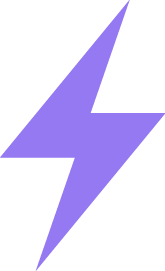

Connected to server at https://desolate-castle-4773.herokuapp.com


<IPython.core.display.Javascript object>

In [117]:
from lightning import Lightning
from numpy import random, asarray
import networkx as nx
from __future__ import division
import math
lgn = Lightning(ipython=True, host='https://desolate-castle-4773.herokuapp.com/')
lgn.set_size(size='large')

TRESHOLD = 2


class idGenerator:
    def __init__(self):
        self.id = 0
    def get(self):
        self.id += 1
        return self.id - 1
    
    
class node:
    def __init__(self, index, label, weight = 30.):
        self.index = index
        self.label = label
        self.childs = []
        self.weight = weight
        self.connections = None
    def addChild( self, c ):
        self.childs.append( c )
        
    def getGraph(self):
        self.connections = []
        graph = nx.Graph()
        graph.add_node( self.index, weight = self.weight, label = self.label, color = (231, 76, 60))
        for c in self.childs:
            graph.add_node( c.index, weight = c.weight, label = c.label, color = (41, 128, 185))
            graph.add_edge(self.index, c.index )
            self.connections.append([ self.index, c.index, 0.1 ])
            for cc in c.childs:
                graph.add_node( cc.index, weight = cc.weight, label = cc.label, color = (236, 240, 241))
                graph.add_edge(c.index, cc.index )
                self.connections.append([ c.index, cc.index, 0. ])
        
        return graph
    
    def getPos(self, sizeX = 5, sizeY = 15):
        X = []
        Y = []
        X.append(0)
        Y.append(  sizeY/2 )
        n = len(self.childs)
        cur = 0
        offset = 0.5
        for i in range(0, n):   
            c = self.childs[i]
            m = len(c.childs)
            w = c.weight
            X.append(3 * sizeX / 5)
            Y.append( cur  )
            offsetY = w * sizeY
            for j in range(0,m):
                # set word nodes position
                X.append( sizeX )# + 0.5* math.cos( 2 * 3.12 * j / m) )
                Y.append( cur + offset +  j/m * w * (sizeY - offset) - offsetY / 2)#+ 0.5 * math.sin( 2 * 3.12 * j / m))
            
            # set topics nodes postions
            cur += offsetY
            
        Y = [ sizeY - y for y in Y]      
        return X,Y
    
def makeGraphFromText( f ):
    id = idGenerator()
    x = complex_topics[f]
    x_topics = x['topics']
    x_details = x['details']
    max_details = x['max_details']
    text_node = node( id.get() , f)
    k = 0
    for i in sorted(x_topics, key=lambda tup: tup[1], reverse = True):
        topic_node = node( id.get(), str(str(i[0]) + ": " + str(str(100.0*i[1])[:4])), weight = 50 * i[1] )
        d = x_details[i[0]]
        for w in sorted(d, key=d.get, reverse=True)[:30]:
            detail_node = node( id.get(), str(str(w) + ": " +  str(d[w])), weight =  20 * float(d[w]) / float(max_details))
            topic_node.addChild(detail_node)
        text_node.addChild( topic_node )
            
    return text_node
   
    



In [122]:
# https://desolate-castle-4773.herokuapp.com/sessions/

f = random.choice(filelist)
G = makeGraphFromText( f )

print f
graph = G.getGraph()
connections = G.connections
X,Y = G.getPos(2 , 30)
mat = asarray(nx.adjacency_matrix(graph).todense())
weights =  nx.get_node_attributes(graph, 'weight').values()
labels = nx.get_node_attributes(graph, 'label').values()
colors = nx.get_node_attributes(graph, 'color').values()

lgn.force(mat, size = weights, labels = labels, color= colors, tooltips = True)

all_source_texts/287_GB_produktbrochure_FeedExpander-en-ru-T.mxliff


In [119]:
# WordCloudTopic(78)

# i = 0
# matplotlib.rcParams['figure.figsize'] = (20.0, 15.0)
# labelsNX = dict()
# for l in labels:
#     labelsNX[i] = l
#     i += 1
    
# i = 0
# weightsNX = dict()
# for l in weights:
#     weightsNX[i] = l
#     i += 1
    
# pos=nx.spring_layout(graph)
# nx.draw(graph, labels = labelsNX,pos = pos, edge_color = 'gray', node_color  = [ [(1.0/255.0) * cc for cc in c]  for c in colors], node_size  = [ 80 * w for w in weights], alpha = 0.7, font_size = 18)

In [120]:
from numpy import random, ceil, array
import numpy as np
x = random.randn(10)
y = random.randn(10)
mat = random.rand(10,10)
mat[mat>0.75] = 0

mat = np.zeros((len(connections), 3))
# lgn = Lightning(ipython=True, host='http://public.lightning-viz.org')
# lgn.set_size(size='large')
print len(x)
print len(connections)
for i in range( 0, len(connections)):
    mat[i,0] = connections[i][0]
    mat[i,1] = connections[i][1]
    mat[i,2] = connections[i][2]
    
mat2 = np.ones((len(X), len(Y)) )
# print mat2
# print X
# print Y

lgn.graphbundled(X,Y,  mat, size = weights, labels = labels, color= colors)




10
150


# similarity

<class 'scipy.sparse.dok.dok_matrix'>
1  |  ('all_source_texts/Turkish_Basketball_Clubs_Evaluationprogramme15-16_Repucom_150612_\xdcbersetzten-en-tr-T.mxliff', 1.0000000566968308)
2  |  ('all_source_texts/ilv_presentation_v13.7_141111_ey_ds-2-en-zh-T.mxliff', 0.95674591929319364)
3  |  ('all_source_texts/Customer needs analysis with ratings_Final[1]-en-fr-T.mxliff', 0.94876382756485156)
4  |  ('all_source_texts/TS-2S iv-EU 3 FEB 2015 WORD-en-nl-T.mxliff', 0.93508166681766347)
5  |  ('all_source_texts/900 GB_Company Profile_2015-en-ru-T.mxliff', 0.92700814734085879)
6  |  ('all_source_texts/Vores ansvar_en-GB-en-it-T.mxliff', 0.91173414189607682)
7  |  ('all_source_texts/Vision & Mission2_en-GB-en-it-T.mxliff', 0.90230347759103013)
8  |  ('all_source_texts/291 GB_ImageBrochure_Petfood_2014-en-ru-T.mxliff', 0.89156117602103901)
9  |  ('all_source_texts/Text variables for on-screen feedback_Final[1]-en-fr-T.mxliff', 0.87893064686857691)
10  |  ('all_source_texts/292 GB_ImageBrochure_Aqua_

<class 'scipy.sparse.dok.dok_matrix'>
1  |  ('all_source_texts/1920-0002 Princess Interiors-en-fr_ca-CR.mxliff', 1.0000000161197748)
2  |  ('all_source_texts/1920-0001 Fairy Interiors-en-fr_ca-CR.mxliff', 0.98111248290310926)
3  |  ('all_source_texts/Welcome Video Script_Final Translation Template_deadline 13. march-en-da-T.mxliff', 0.90494402882862168)
4  |  ('all_source_texts/ELX Weekly Wellness Tips v3-en-da-T.mxliff', 0.89893464882112939)
5  |  ('all_source_texts/Beth\xb9s Blog 2 v1-en-da-T.mxliff', 0.88896874279535898)
6  |  ('all_source_texts/Beth\xb9s Blog 3 v3-en-da-T.mxliff', 0.87821154773195187)
7  |  ('all_source_texts/Best of the Best Weekly Tips v4-en-da-T.mxliff', 0.87542968411718081)
8  |  ('all_source_texts/EL GMTC_Final Translation Template (2)_deadline 20. april-en-da-T.mxliff', 0.87412108398437671)
9  |  ('all_source_texts/Re-Nutriv Script_Final Translation Template_deadline 20. april-en-da-T.mxliff', 0.86026551537180973)
10  |  ('all_source_texts/Beth\xb9s Blog 1 v3